## Imports

In [1]:
from __future__ import print_function
from __future__ import division

# Standard Library, plus some Third Party Libraries
from pprint import pprint
from PIL import Image
from tqdm import tqdm

import copy
import datetime
import h5py
import math
import os
import random
import sys
import time
# import visdom

# Data Science and Machine Learning Libraries
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# TorchVision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.utils import save_image

import torchsummary

In [2]:
print("Sklearn Version: ", sklearn.__version__)

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

Sklearn Version:  0.22.2.post1
PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


In [3]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup Notebook

### Set Seeds & Set Device

In [4]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (torch.device('cuda:0') if torch.cuda.is_available()
    else torch.device('gpu'))
print(f"Training on device {device}.")
print(f"# cuda device: {torch.cuda.device_count()}")
print(f"Id current device: {torch.cuda.current_device()}")

Training on device cuda:0.
# cuda device: 1
Id current device: 0


### Globals

In [6]:
image_path = "/content/test001.png"

if os.path.exists('/content/outputs/') is False:
    os.makedirs('/content/outputs/')
elif os.path.isdir('/content/outputs/') is False:
    raise Exception("'/content/outputs/' should be output directory aimed at recording output results, from performed analysis!")

model_state_path = '/content/outputs/model.pth' # '../outputs/model.pth'
loss_image_path = '/content/outputs/loss.png' # '../outputs/loss.png'
psnr_image_path = '/content/outputs/psnr.png' # '../outputs/psnr.png'

### Functions

In [7]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [8]:
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

#### Graphics

In [9]:
def show_graphic_series_via_plot(
    series,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value'
    ):
    plt.figure(figsize=figsize)
    plt.plot(series, color=color, label=label)
    # plt.plot(val_loss, color='red', label='validataion loss')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(image_path)
    plt.show()
    pass

def show_graphic_series_via_ax(
    series,
    ax,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value'
    
    ):
    ax.plot(series, color=color, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    pass

def show_graphic_series(
    series,
    image_path = "graphic_series.png", figsize=(10, 7),
    title = "Series Graphic",
    color='orange', label='data series',
    xlabel = 'pos', ylabel = 'value',
    ax = None
    ):
    if ax is None:
        show_graphic_series_via_plot(
        series = series,
        image_path = image_path,
        title = title,
        figsize = figsize,
        color = color,
        label = label,
        xlabel = xlabel,
        ylabel = ylabel
    )
    else:
        show_graphic_series_via_ax(
        series = series,
        ax = ax,
        image_path = image_path,
        title = title,
        figsize = figsize,
        color = color,
        label = label,
        xlabel = xlabel,
        ylabel = ylabel
    )
    pass

def plot_loss_graphic(loss_data, config):
    show_graphic_series(
        series = loss_data,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel
    )
    pass

def plot_psnr_graphic(psnr_data, config):
    show_graphic_series(
        series = psnr_data,
        image_path = config.image_path,
        title = config.title,
        figsize = config.figsize,
        color = config.color,
        label = config.label,
        xlabel = config.xlabel,
        ylabel = config.ylabel
    )
    pass

In [48]:
def plot_complex_graphics_series(s, title = 'Comples Series'):
    fig, axs = plt.subplots(3, figsize=(10, 10))
    fig.suptitle(title)

    s.plot(kind='hist', ax = axs[0])
    s.plot(kind='kde', ax=axs[0], secondary_y=True, label = f'{title} - kde') # ax = s.plot.kde()
    axs[0].set_title(f'{title}: Hist - KDE')
    plt.legend()

    s.plot(kind='box', ax = axs[1], label='line')
    axs[1].set_title(f'{title}: Box Plot')

    s.plot(kind='bar', ax = axs[2])
    s.plot(kind='line', ax=axs[2], secondary_y=False, color = 'blue', label = f'{title} - line') 
    axs[2].set_title(f'{title}: Line - Bars')

    plt.legend()
    pass

### Classes

#### Config Class

In [10]:
class Config:  
    def __init__(self, **kwargs):
      for key, value in kwargs.items():
          setattr(self, key, value)
      pass
    pass

class PlotConfig(Config):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    pass

#### Data Loaders

In [11]:
# the dataset module
class SirenDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float))

class ImageFitting(Dataset):
    def __init__(self, sidelength, image_path = None):
        super().__init__()
        if image_path is None:
            img = get_cameraman_tensor(sidelength)
        else:
            imag = Image.open(image_path)
            imag = imag.resize((sidelength, sidelength))
            # printImageAttributes(imag, image_path)
            # imag = np.asarray(imag)
            transform = Compose([
                Resize(sidelength),
                ToTensor(),
                Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
            ])
            img = transform(imag)
            pass
        
        # print(type(img))
        # print(img.size())

        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        pass

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels
    pass

#### Siren Architecture

In [12]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Run Notebook

### Training and Validation Functions

In [13]:
def train(model, dataloader, criterion, optimizer, train_size, device):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    # for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
    for bi, data in enumerate(dataloader):
        image_data = data[0].to(device)
        label = data[1].to(device)

        
        outputs, coords = model(image_data)    
        loss = criterion(outputs, label)

        optimizer.zero_grad()
            
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

        loss.backward()
        optimizer.step()
        pass
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(train_size/dataloader.batch_size)
    return final_loss, final_psnr

In [14]:
def validate(model, dataloader, epoch, criterion, train_size):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        # for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        for bi, data in enumerate(dataloader):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
        outputs = outputs.cpu()
        save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(train_size/dataloader.batch_size)
    return final_loss, final_psnr

In [15]:
def training_loop(model, train_loader, criterion, optimizer, train_size, device, epochs = 100, verbose = 0):
    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []

    globaliter = 0
    start = time.time()
    for epoch in range(epochs):
        if verbose == 1:
            print(f"Epoch {epoch + 1} of {epochs}")
        train_epoch_loss, train_epoch_psnr = train(model, train_loader, criterion, optimizer, train_size, device)
        # val_epoch_loss, val_epoch_psnr = validate(model, val_loader, epoch)

        if verbose == 1:
            print(f"Train Loss: {train_epoch_loss:.3f} | Train PSNR: {train_epoch_psnr:.3f}")
            # print(f"Val PSNR: {val_epoch_psnr:.3f}")
    
        globaliter += 1

        train_loss.append(train_epoch_loss) # val_loss.append(val_epoch_loss)
        train_psnr.append(train_epoch_psnr) # val_psnr.append(val_epoch_psnr)
        pass
    end = time.time()
    if verbose == 1:
        print(f"Finished training in: {((end-start)/60):.3f} minutes")

    history_keys_list = 'train_loss;train_psnr'.split(";")
    history_values_list = [np.array(series) for series in [train_loss, train_psnr]]
    
    history = dict(zip(history_keys_list, history_values_list))
    return model, history

In [16]:
def repeat_training_loop_siren(n_times, config_loader, config_model, config_hyperparams, verbose = 0):

    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []

    for trial_no in range(n_times):
        if verbose == 1:
            print(f"Trial no. {trial_no + 1} of {n_times}")
        
        # Fetch Data
        train_data = ImageFitting(config_loader.sidelenght, config_loader.image_path)
        train_loader = DataLoader(train_data,
            batch_size=1,
            pin_memory=True,
            num_workers=0)
        
        # Create Siren Model
        model = Siren(
            in_features = config_model.in_features,
            hidden_features = config_model.hidden_features,
            hidden_layers = config_model.hidden_layers,
            out_features = config_model.out_features,
            outermost_linear = True, 
            first_omega_0 = 30,
            hidden_omega_0 = 30.
        ).to(config_model.device)
        # print(model)

        # Optimizer Initialization
        optimizer = optim.Adam(model.parameters(),
            lr=config_hyperparams.lr)
        # Loss Function Initialization
        criterion = nn.MSELoss()

        # Run training
        model, history = training_loop( 
            model, train_loader,
            criterion, optimizer,
            train_size = len(train_data),
            device = config_model.device,
            epochs = config_hyperparams.epochs, verbose = config_hyperparams.verbose)
        
        train_loss.append(history['train_loss'][-1])
        train_psnr.append(history['train_psnr'][-1])
        if verbose == 1:
            print(f"Train Loss: {history['train_loss'][-1]:.3f} | Train PSNR: {history['train_psnr'][-1]:.3f}")
        
    keys_list = 'train_loss;train_psnr'.split(";")
    values_list = [np.array(series) for series in [train_loss, train_psnr]]

    history = dict(zip(keys_list, values_list))
    return history

### Fit Model

In [17]:
# Hyper-params
lr = 1e-4
sidelenght = 256

epochs = 100
n_times = 10

In [18]:
# Config Objects
config_loader = Config(
    sidelenght = sidelenght,
    image_path = image_path
)

config_model = Config(
    in_features = 2,
    hidden_features = sidelenght,
    hidden_layers = 3,
    out_features = 1,
    device = device,
)

config_hyperparams = Config(
    lr = 1e-4,
    epochs = 100,
    verbose = 0
)

In [19]:
history = repeat_training_loop_siren(n_times, config_loader, config_model, config_hyperparams, verbose = 1)

Trial no. 1 of 10
Train Loss: 0.019 | Train PSNR: 17.200
Trial no. 2 of 10
Train Loss: 0.018 | Train PSNR: 17.382
Trial no. 3 of 10
Train Loss: 0.019 | Train PSNR: 17.227
Trial no. 4 of 10
Train Loss: 0.019 | Train PSNR: 17.241
Trial no. 5 of 10
Train Loss: 0.019 | Train PSNR: 17.220
Trial no. 6 of 10
Train Loss: 0.019 | Train PSNR: 17.311
Trial no. 7 of 10
Train Loss: 0.019 | Train PSNR: 17.118
Trial no. 8 of 10
Train Loss: 0.019 | Train PSNR: 17.238
Trial no. 9 of 10
Train Loss: 0.019 | Train PSNR: 17.308
Trial no. 10 of 10
Train Loss: 0.019 | Train PSNR: 17.237


In [20]:
pprint(history)

{'train_loss': array([0.01905638, 0.01827425, 0.01893659, 0.01887567, 0.01896675,
       0.01857581, 0.01941856, 0.01889005, 0.01858529, 0.01889146]),
 'train_psnr': array([17.19959515, 17.38160405, 17.22698153, 17.24097631, 17.22007096,
       17.31052242, 17.11783063, 17.23766994, 17.30830553, 17.23734535])}


In [21]:
index_trials = [f"trial no.{ii:.0f}" for ii in range(n_times)]
train_loss_df = pd.DataFrame(data = history['train_loss'][:, np.newaxis], columns=['train_loss'], index = index_trials)
train_psnr_df = pd.DataFrame(data = history['train_psnr'][:, np.newaxis], columns=['train_psnr'], index = index_trials)

history_df = train_loss_df.join(train_psnr_df)

In [22]:
history_df.describe()

,train_loss,train_psnr
count,10.000000,10.000000
mean,0.018847,17.248090
std,0.000310,0.071627
min,0.018274,17.117831
25%,0.018658,17.221799
50%,0.018891,17.237508
75%,0.018959,17.291473
max,0.019419,17.381604


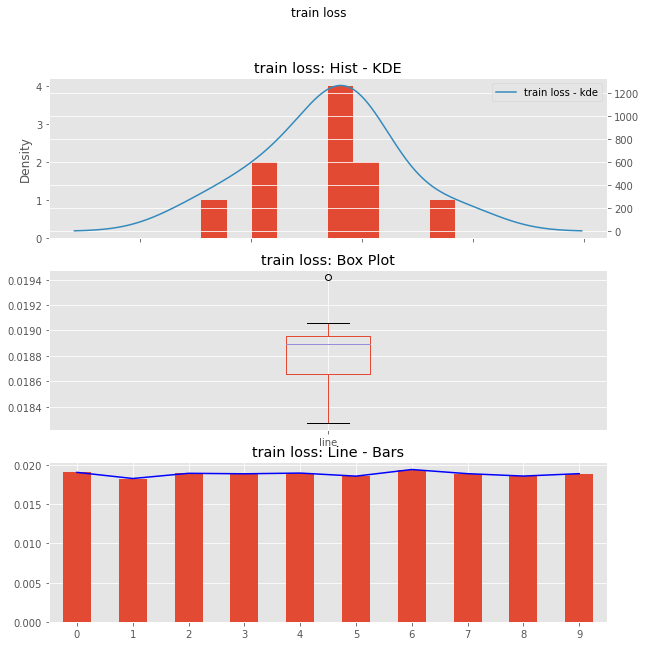

In [49]:
series_train_loss = pd.Series(history_df['train_loss'].values)
plot_complex_graphics_series(s = series_train_loss, title = 'train loss')

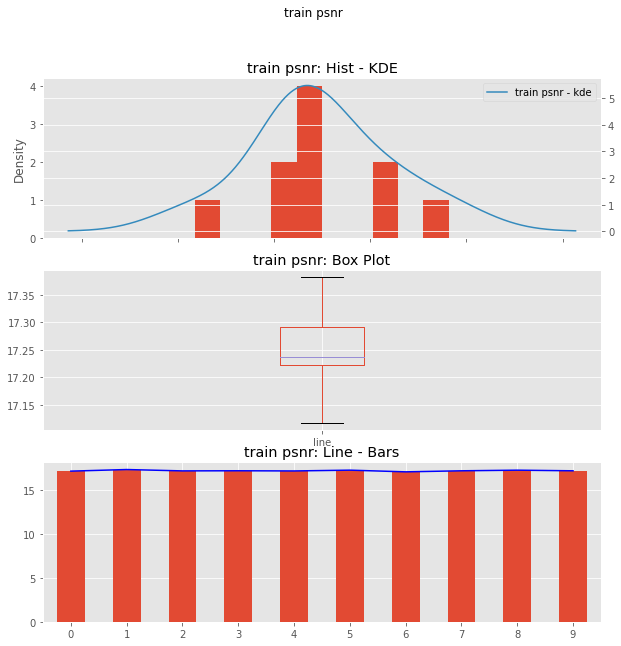

In [51]:
series_train_psnr = pd.Series(history_df['train_psnr'].values)
plot_complex_graphics_series(s = series_train_psnr, title = 'train psnr')

### Show Graphics

## References

- Pytorch Reference's Manual:
 - [torch.nn module](https://pytorch.org/docs/stable/nn.html)
 - [TensorBoard Support](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
 - [Train Example](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code)

- Initialization Topic (Papers):
  - [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by X. Glorot & Y.Bengio, which lead to default Pytorch's weights initialization knwon as *Xavier initialization* algorithm or scheme
 -  [Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/abs/1901.09321) by Hongyi Zhang, Yann N. Dauphin, Tengyu Ma, whose works allows to *get rid off batch normalization layers* with a given particular NN Arch, to still be able to train a NN arch with meaningful and confident results or performance.

- Activation Functions (Papers):
  - [Deep Learning using Rectified Linear Units (ReLU)](https://arxiv.org/pdf/1803.08375.pdf)

- Datasets:
  - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

- Regularization techniques (Papers):
  - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shif](https://arxiv.org/abs/1502.03167)
  - [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

- Archs Types (Papers):
  - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
  - [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)
  - [Highway Networks
](https://arxiv.org/pdf/1505.00387.pdf)
  - [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

- Some Third Party useful Tutorials:
 - [Imagenet example](https://github.com/pytorch/examples/blob/master/imagenet/main.py#L327)
 - [Writing a better code with pytorch and einops](https://arogozhnikov.github.io/einops/pytorch-examples.html)
 - [Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric - MEDIUM](https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8)
 - [Pytorch Example](https://pythonprogramming.net/analysis-visualization-deep-learning-neural-network-pytorch/)

- Books
  - [List of books for improving Pytorch knowledge](https://bookauthority.org/books/best-pytorch-books)

- GitHub Projetcs:
  - [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)
  - [Minetorch](https://github.com/minetorch/minetorch)
  - [Pierogi](https://github.com/nalepae/pierogi/)
  - [Visdom](https://github.com/facebookresearch/visdom#vismatplot)

- Tensorboard:
  - [A Quickstart Guide to TensorBoard](https://towardsdatascience.com/a-quickstart-guide-to-tensorboard-fb1ade69bbcf)
  - [How to use Tensorboard with PyTorch in Google Colab](https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34)
  - [VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)